In [1]:
import sys
sys.path.append("/home/twhit/smc_object_detection/")

from utils.misc import select_cuda_device
device = select_cuda_device()

Selected device 4, which has 10820 MB available.


In [2]:
import torch
from torch.distributions import Poisson

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from scipy.stats import truncpareto

from hydra import initialize, compose
from hydra.utils import instantiate

from astropy.io import fits
from astropy.wcs import WCS

from bliss.catalog import FullCatalog, convert_mag_to_nmgy, convert_nmgy_to_mag

In [3]:
with initialize(config_path=".", version_base=None):
    cfg = compose(config_name="config")

---

### SDSS image

In [4]:
sdss = instantiate(cfg.surveys.sdss)
sdss.prepare_data()

In [5]:
field52_rband_fits = fits.open('/data/scratch/twhit/m71/6895/3/52/frame-r-006895-3-0052.fits')
field52_rband_wcs = WCS(field52_rband_fits[0].header)

# We will catalog a 320x320 pixel region with lower left corner at (1728, 900)
field52_rband_wcs.pixel_to_world(1728, 900)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<SkyCoord (ICRS): (ra, dec) in deg
    (298.40759022, 18.78339333)>

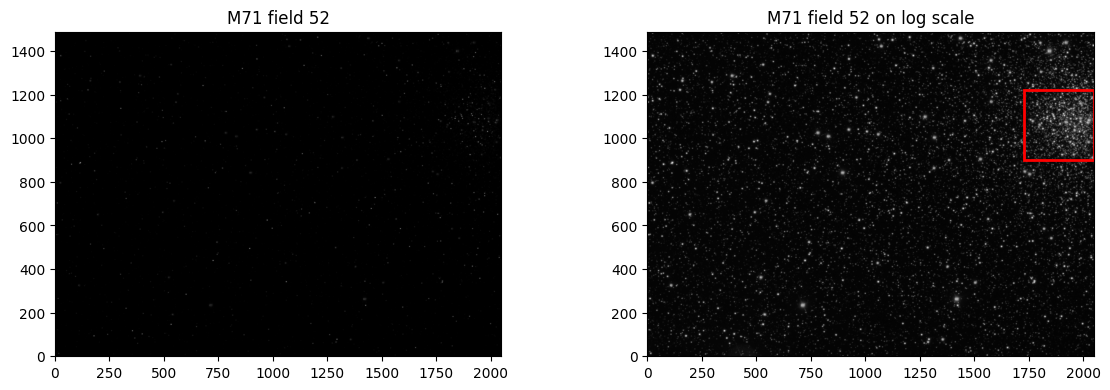

In [6]:
field52_image = field52_rband_fits[0].data
field52_image_arcsinh = np.arcsinh(field52_image)

fig, ax = plt.subplots(1, 2, figsize = (12, 4))
rect = Rectangle((1728, 900), 320, 320, linewidth=2, edgecolor='r', facecolor='none')

_ = ax[0].imshow(field52_image, origin='lower', cmap='gray')
_ = ax[0].set_title('M71 field 52')

_ = ax[1].imshow(field52_image_arcsinh, origin='lower', cmap='gray')
_ = plt.gca().add_patch(rect)
_ = ax[1].set_title('M71 field 52 on log scale')

_ = fig.tight_layout()

---

### Hubble catalog

All magnitudes and fluxes are in the r-band.

In [7]:
# wget https://archive.stsci.edu/pub/hlsp/acsggct/ngc6838/hlsp_acsggct_hst_acs-wfc_ngc6838_r.rdviq.cal.adj.zpt

hubble_catalog = np.loadtxt('/data/scratch/twhit/m71/hlsp_acsggct_hst_acs-wfc_ngc6838_r.rdviq.cal.adj.zpt',
                            skiprows = 3, usecols=(9, 21, 22))

In [8]:
mags_all = torch.from_numpy(hubble_catalog[:,0])
fluxes_all = convert_mag_to_nmgy(mags_all)

ra_all = torch.from_numpy(hubble_catalog[:,1])
dec_all = torch.from_numpy(hubble_catalog[:,2])

locs_all = FullCatalog.plocs_from_ra_dec(ra_all, dec_all, field52_rband_wcs)

In [9]:
locs_mask = (locs_all[:,0] > 900) & (locs_all[:,0] < 1220)
locs_mask &= (locs_all[:,1] > 1728) & (locs_all[:,1] < 2048)

locs = locs_all[locs_mask]
locs -= locs.min(0).values
mags = mags_all[locs_mask]
fluxes = fluxes_all[locs_mask]

In [10]:
mag_threshold = 23.0

locs_magcut = locs[mags <= mag_threshold]
mags_magcut = mags[mags <= mag_threshold]
fluxes_magcut = fluxes[mags <= mag_threshold]

---

### Store image tiles and tile catalogs

In [11]:
tile_dim = 8
max_objects_per_tile = 25

# Subset to the 320x320 pixel region and partition it into 8x8 pixel tiles
image = torch.from_numpy(field52_image[900:1220, 1728:2048].astype(np.float32))
tiles = image.unfold(0, tile_dim, tile_dim).unfold(1, tile_dim, tile_dim)

In [12]:
locs_index = locs // tile_dim
tile_counts = torch.zeros(tiles.shape[0], tiles.shape[1])
tile_locs = torch.zeros(tiles.shape[0], tiles.shape[1], max_objects_per_tile, 2)
tile_mags = torch.zeros(tiles.shape[0], tiles.shape[1], max_objects_per_tile)
tile_fluxes = torch.zeros(tiles.shape[0], tiles.shape[1], max_objects_per_tile)

locs_index_magcut = locs_magcut // tile_dim
tile_counts_magcut = torch.zeros(tiles.shape[0], tiles.shape[1])
tile_locs_magcut = torch.zeros(tiles.shape[0], tiles.shape[1], max_objects_per_tile, 2)
tile_mags_magcut = torch.zeros(tiles.shape[0], tiles.shape[1], max_objects_per_tile)
tile_fluxes_magcut = torch.zeros(tiles.shape[0], tiles.shape[1], max_objects_per_tile)

for h in range(tiles.shape[0]):
    for w in range(tiles.shape[1]):
        tile_counts[h,w] = (locs_index == torch.tensor([h,w])).all(-1).sum()
        tile_locs[h,w,:tile_counts[h,w].int()] = (locs % tile_dim)[(locs_index == torch.tensor([h,w])).all(-1)]
        tile_mags[h,w,:tile_counts[h,w].int()] = mags[(locs_index == torch.tensor([h,w])).all(-1)]
        tile_fluxes[h,w,:tile_counts[h,w].int()] = fluxes[(locs_index == torch.tensor([h,w])).all(-1)]
        
        tile_counts_magcut[h,w] = (locs_index_magcut == torch.tensor([h,w])).all(-1).sum()
        tile_locs_magcut[h,w,:tile_counts_magcut[h,w].int()] = (locs_magcut % tile_dim)[(locs_index_magcut == torch.tensor([h,w])).all(-1)]
        tile_mags_magcut[h,w,:tile_counts_magcut[h,w].int()] = mags_magcut[(locs_index_magcut == torch.tensor([h,w])).all(-1)]
        tile_fluxes_magcut[h,w,:tile_counts_magcut[h,w].int()] = fluxes_magcut[(locs_index_magcut == torch.tensor([h,w])).all(-1)]

In [13]:
checkerboard_mask = torch.tensor([[((h + w) % 2 == 0) for w in range(tiles.shape[1])] for h in range(tiles.shape[0])])

In [14]:
torch.save(tiles[checkerboard_mask], 'data/tiles.pt')

torch.save(tile_counts[checkerboard_mask], 'data/counts.pt')
torch.save(tile_locs[checkerboard_mask], 'data/locs.pt')
torch.save(tile_mags[checkerboard_mask], 'data/mags.pt')
torch.save(tile_fluxes[checkerboard_mask], 'data/fluxes.pt')

torch.save(tile_counts_magcut[checkerboard_mask], 'data/counts_magcut.pt')
torch.save(tile_locs_magcut[checkerboard_mask], 'data/locs_magcut.pt')
torch.save(tile_mags_magcut[checkerboard_mask], 'data/mags_magcut.pt')
torch.save(tile_fluxes_magcut[checkerboard_mask], 'data/fluxes_magcut.pt')

---

### Flux prior

We fit a flux prior using the tiles that were not stored above (i.e., the opposite-color squares on the checkerboard).

In [15]:
# Filter to sources outside the 320x320 pixel region with r-band mag below the threshold
mags_magcut_oob = tile_mags_magcut[~checkerboard_mask][tile_mags_magcut[(~checkerboard_mask)] > 0]
fluxes_magcut_oob = tile_fluxes_magcut[~checkerboard_mask][tile_mags_magcut[(~checkerboard_mask)] > 0]

In [16]:
alpha, trunc, loc, scale = truncpareto.fit(fluxes_magcut_oob)
print(f"alpha = {alpha}, trunc = {trunc}, loc = {loc}, scale = {scale}")

alpha = 0.7722782398988779, trunc = 2176.0789193441756, loc = -5.982667968670065, scale = 6.614787859711891


/home/twhit/smc_object_detection/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:10571: RuntimeWarning: divide by zero encountered in divide
  return 1/np.mean(1/x)
/home/twhit/smc_object_detection/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:10634: RuntimeWarning: divide by zero encountered in scalar divide
  return (1 + 1/(c-1)) * np.log(c) / harm_m - 1
/home/twhit/smc_object_detection/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:10643: RuntimeWarning: invalid value encountered in scalar multiply
  and (cond_b(lbrack)*cond_b(rbrack) >= 0)):
/home/twhit/smc_object_detection/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:10577: RuntimeWarning: invalid value encountered in scalar divide
  quot = (harm_m-1)/log_m


In [17]:
f = np.logspace(np.log10(fluxes_magcut_oob.min().item()), np.log10(trunc), 200)
pf = truncpareto.pdf(f, alpha, trunc, loc, scale)

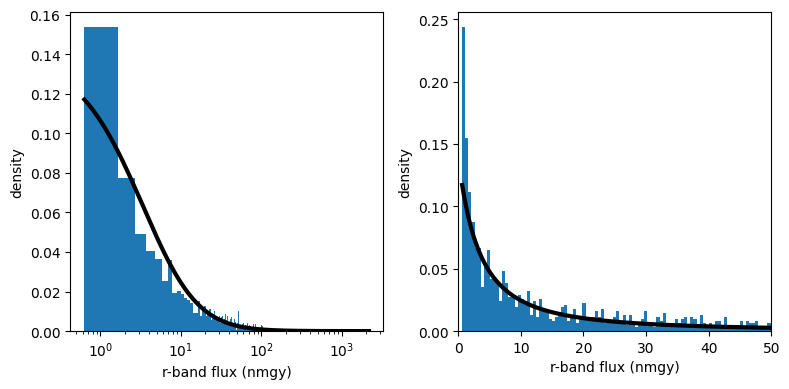

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))
_ = ax[0].plot(f, pf, color = 'black', linewidth = 3)
_ = ax[0].hist(fluxes_magcut_oob[fluxes_magcut_oob < trunc], density = True, bins = 2000)
_ = ax[0].set_xscale('log')
_ = ax[0].set_xlabel('r-band flux (nmgy)')
_ = ax[0].set_ylabel('density')

_ = ax[1].plot(f, pf, color = 'black', linewidth = 3)
_ = ax[1].hist(fluxes_magcut_oob[fluxes_magcut_oob < 50], density = True, bins = 100)
_ = ax[1].set_xlim(0, 50)
_ = ax[1].set_xlabel('r-band flux (nmgy)')
_ = ax[1].set_ylabel('density')

_ = fig.tight_layout()

---

### Count prior

We fit a flux prior using the tiles that were not stored above (i.e., the opposite-color squares on the checkerboard).

In [19]:
counts_magcut_oob = tile_counts_magcut[~checkerboard_mask]

In [20]:
# MLE of Poisson rate parameter
rate = (counts_magcut_oob.sum() / ((~checkerboard_mask).sum()))
print(f"rate = {rate.item()}")

rate = 2.0225000381469727


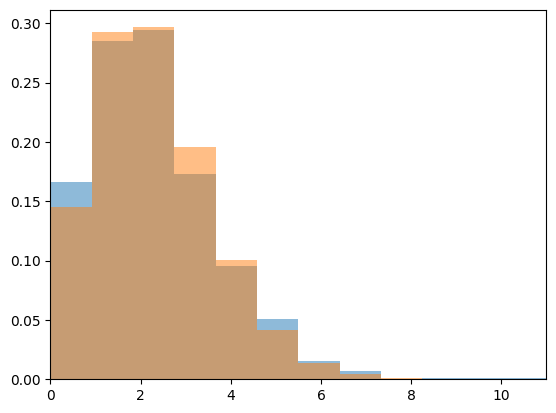

In [21]:
_ = plt.hist(counts_magcut_oob, bins = 12, density = True, alpha = 0.5, label = '')

random_sample = Poisson(rate).sample([100000])
_ = plt.hist(random_sample, bins = random_sample.max().int() + 1, density = True, alpha = 0.5)
_ = plt.xlim(0, 11)

---

### Image model

We plot the r-band background of the entire SDSS field:

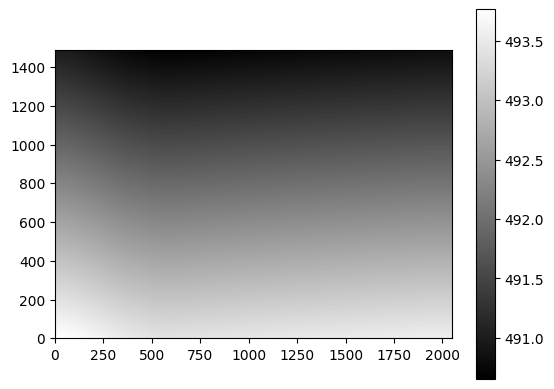

In [22]:
_ = plt.imshow(sdss[0]["background"][2], cmap = 'gray', origin = 'lower')
_ = plt.colorbar()

In [23]:
sdss_background = sdss[0]["background"][2][900:1220, 1728:2048]
print(f'background mean = {sdss_background.mean()}, background std = {sdss_background.std()}')

background mean = 491.5867919921875, background std = 0.1711219996213913


Now we plot the r-band SDSS psf:

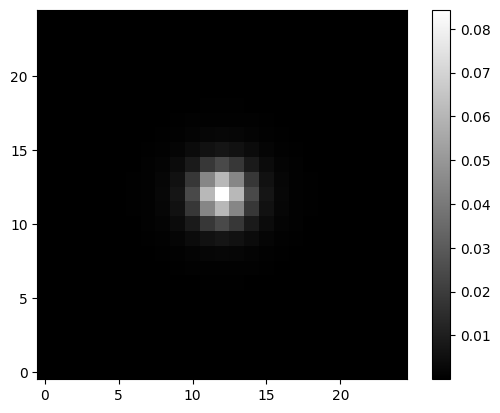

In [24]:
sdss_psf = sdss.psf.psf_galsim[sdss.image_id(0)][2].original.image.array

_ = plt.imshow(sdss_psf, cmap = 'gray', origin = 'lower')
_ = plt.colorbar()

---